In [7]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms.functional as f
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable
import torch
import random

In [123]:
# ### 3-layers
# x = torch.randn(1,3,2,2)
# epsilon = 0.01
# model = nn.Sequential(
#     nn.Conv2d(3,2,2,1,2),
#     nn.ReLU(),
#     nn.MaxPool2d(3),
#     nn.Conv2d(2,3,2,2,2),
#     nn.ReLU(),
#     nn.MaxPool2d(2),
#     nn.Conv2d(3,1,2,1,1)
# )


# y = model(x)
# print('y:',y.shape)

In [124]:
x = torch.randn(1,3,2,2)
epsilon = 0.01
model = nn.Sequential(
    nn.Conv2d(3,2,2,1,2),
    nn.ReLU(),
    nn.MaxPool2d(3),
    nn.Conv2d(2,1,2,2,1),
)


y = model(x)

#print('x:',x.data)
#print('\n')
print('y:',y.shape)

y: torch.Size([1, 1, 1, 1])


In [125]:
# x = torch.randn(1,1,4,4)
# epsilon = 0.8
# model = nn.Sequential(
#     nn.Conv2d(1,2,2,1,0),
#     nn.ReLU(),
#     nn.MaxPool2d(2),
#     nn.Conv2d(2,1,2,1,1),
# )


# y = model(x)
# y

### backward

In [126]:
# def get_upper_lower

### get middle upper lower bounds

In [127]:
def get_lR_uR(zl,zu):
    
    uR = (zu > 0).detach().type_as(zu) * zu
    lR = (zl > 0).detach().type_as(zl) * zl
    
    return uR, lR

### Find D matrix

In [128]:
def get_matrix_d(zl,zu):
    
    d = (zl >= 0).detach().type_as(zl) # d check each point in I+ set
    I = ((zu > 0).detach() * (zl < 0).detach()) # I check each point in I set

    if I.sum().item() > 0:
            d[I] += zu[I]/(zu[I] - zl[I])
    
    d = d.t() # create the D matrix(in paper)
    
    return d

In [129]:
def premute_pixels(lR, uR, kM):
    
    kh, kw = kM, kM  # kernel size
    dh, dw = kM, kM  # stride
    
    lR_patches = lR.unfold(2, kh, dh).unfold(3, kw, dw)
    uR_patches = uR.unfold(2, kh, dh).unfold(3, kw, dw)
    
    unfold_shape = lR_patches.size()
    
    lR_patches = lR_patches.contiguous().view(lR_patches.size(0), -1, kh*kw)
    uR_patches = uR_patches.contiguous().view(uR_patches.size(0), -1, kh*kw)
    
    return uR_patches, lR_patches, unfold_shape

In [130]:
LM_bds = []
UM_bds = []

def get_bar_u_l(lR, uR, reshape_size, kernel_size_M):
    
    lR = lR.contiguous().view(*reshape_size)
    uR = uR.contiguous().view(*reshape_size)
    
    # permute the pixels which using for max-pool
    uR, lR, unfold_shape = premute_pixels(lR, uR, kernel_size_M)
    
    #print('new lR:',lR.size()) #lR size(1,8,4)
    
    n = lR.size(1)
    lM = torch.zeros(1,n)
    uM = torch.zeros(1,n)
    
    L_bar_bds = []
    U_bar_bds = []
    
    pixels_len = kernel_size_M * kernel_size_M # 每次kernel經過的pixel數
    
    for idx in range(pixels_len):
        #print(lR[:,:,idx])
        
        # get l_bar , u_bar
        l_bar = lR[:,:,idx] - uM
        u_bar = uR[:,:,idx] - lM
        
        L_bar_bds.append(l_bar)
        U_bar_bds.append(u_bar)
        
        # get l', u'
        l_ = (l_bar > 0).detach().type_as(l_bar) * l_bar
        u_ = (u_bar > 0).detach().type_as(u_bar) * u_bar
        
        # get new lM, uM
        lM = lM + l_
        uM = uM + u_
    
    L_bar = torch.stack(L_bar_bds, dim = 0)
    U_bar = torch.stack(U_bar_bds, dim = 0)
    
    #print('L_bar_bds:',L_bar_bds)
    #print('L_bar:',L_bar)
    
    ### use for test maxpool layer's upper/lower bound
    LM_bds.append(lM)
    UM_bds.append(uM)
    
    return U_bar, L_bar

In [131]:
def get_Kappa(Rho, d_bar, unfold_shape, pad_num):
    
    list_Kappa = []
    
    #print('Rho :',Rho.shape)
    #print('d_bar:',d_bar.shape)
    for idx in range(d_bar.size(0)-1,-1,-1):
        kappa = d_bar[idx]*Rho
        Rho -= kappa
        list_Kappa.append(kappa)
    
    #print('list_Kappa:\n',list_Kappa)
    
    Kappa = torch.stack(list_Kappa, dim = 1)
    Kappa = torch.flip(Kappa,[1])
    #print('flip kappa:',torch.sum(Kappa.clamp(min = 0),(3,2,1)))
    kappa_hat = Kappa
    
    Kappa = Kappa.permute(0,2,3,1)
    #print('Kappa [1]:\n',Kappa[3])

    Kappa_orig = Kappa.view(Kappa.size(0),*unfold_shape[1:])
    
    output_h = unfold_shape[2] * unfold_shape[4]
    output_w = unfold_shape[3] * unfold_shape[5]
    
    Kappa_orig = Kappa_orig.permute(0, 1, 2, 4, 3, 5).contiguous()
    Kappa_orig = Kappa_orig.view(Kappa.size(0), unfold_shape[1], output_h, output_w)
    
    # padding
    p1d = (0,pad_num,0,pad_num)
    Kappa_orig = F.pad(Kappa_orig, p1d, "constant", 0) 
    
    #print('Kappa_orig [3]:\n',Kappa_orig[3])
    
    return Kappa_orig, kappa_hat

In [132]:
# backward 
    
def get_upper_lower(x, epsilon, model, out_layer_size, 
                    D = None, Lower = None, Upper = None, 
                    D_bar = None, bar_Lower = None, bar_Upper = None):
    
    nu = []
    n = out_layer_size[-1][1]*out_layer_size[-1][2]*out_layer_size[-1][3]
    nu.append(torch.eye(n).view(n,*out_layer_size[-1][1:]))
        
    nu_b = []
    nu_x = [x]
    l1 = []
    Big_Kappa = []
    
    upper_max_pool_term = []
    lower_max_pool_term = []
    
    upper_relu_term = []
    lower_relu_term = []
    

    model_len = len(out_layer_size)
    
    #print('n,nu.size():',n,nu[-1].size())
    #print('out_layer_size:',out_layer_size)
    
    
    if D != None :
        pos_Upper = len(Upper) - 1
        pos_Lower = len(Lower) - 1
        pos_bar_U = len(bar_Upper) - 1
        pos_bar_L = len(bar_Lower) - 1
        pos_d = len(D) - 1
        pos_bar_d = len(D_bar) -1
    
    for idx, layer in enumerate(reversed(model)):
        
        
        if isinstance(layer, nn.Conv2d):

            ### declare the nus
            pos = (model_len - 1) - idx
            flat_num = out_layer_size[pos][1]*out_layer_size[pos][2]*out_layer_size[pos][3]


            # accroding to this layer's output picture size (output means the forward result via this layer)
            # 每張圖被 flat 成 vector 後 ，vector中所含的 neuro數，為每張圖的 total neuros = W*H*Chl
            nus = nu[-1].flatten().view(n,flat_num).t() 

            ### get the weight and bias

            in_chl = layer.out_channels
            out_chl = layer.in_channels
            kernel_size = layer.kernel_size[0]
            stride = layer.stride[0]
            pad = layer.padding[0]

            in_size = out_layer_size[pos-1][2]
            out_size = out_layer_size[pos][2]

            out_pad = in_size - (out_size -1)* stride + 2*pad - kernel_size

            dc = nn.ConvTranspose2d(in_chl,out_chl,kernel_size,stride,pad,bias = False,output_padding = out_pad)
            dc.weight = layer.weight
            b = layer.bias
            b = b.view(b.size()[0],1).expand(b.size()[0],out_layer_size[pos][2]*out_layer_size[pos][3])
            b = b.flatten().unsqueeze(0)
            ### get nu and nu_b

            nu_b.append(torch.mm(b,nus))
            nu.append(dc(nu[-1]))

            print('dc nu:',nu[-1].size())
            #print('nu_b:',nu_b[-1].size())
        
        if isinstance(layer, nn.MaxPool2d):
            print('max-pool')
            
            # get unfold shape
            pos = (model_len - 1) - idx - 1 
            temp = torch.rand(*(out_layer_size[pos])) # out_layer_size[pos] is size after ReLU layer (f_l) 
            
            kM = layer.kernel_size
            kh, kw = kM, kM  # kernel size
            dh, dw = kM, kM  # stride
            
            patches = temp.unfold(2, kh, dh).unfold(3, kw, dw)
            unfold_shape = patches.size()
            
            # get kappa
            Beta = nu[-1].view(n,1,-1)
            Rho = Beta
            # prepare for padding size
            N_l = out_layer_size[pos+1][2] # out_layer_size[pos] is size after max-pool layer (N_l) 
            f_l = out_layer_size[pos][2]   # out_layer_size[pos] is size after ReLU layer (f_l) 
            r_l = 2*N_l + kM -2
            pad_num = f_l - r_l
            
            Kappa_orig, kappa_hat = get_Kappa(Rho, D_bar[pos_bar_d], unfold_shape, pad_num)
            print('Kappa_orig:',Kappa_orig.shape)
            Big_Kappa.append(Kappa_orig)
            
            # count max_pool_term
            bar_I = ((bar_Upper[pos_bar_U] > 0).detach() * (bar_Lower[pos_bar_L] < 0).detach()).float()
            
            upper_max_pool_term.append( torch.sum( bar_Lower[pos_bar_L]*(bar_I*kappa_hat).clamp(0), (3,2,1) ) )
            lower_max_pool_term.append( torch.sum( bar_Lower[pos_bar_L]*(-1*bar_I*kappa_hat).clamp(0), (3,2,1) ) )
        
        if isinstance(layer, nn.ReLU):
            print('\nReLU')
            
            flat_num = torch.numel(Big_Kappa[-1][0])
            nus = Big_Kappa[-1].flatten().view(n,flat_num)* d[pos_d] 
            origin_size = Big_Kappa[-1].size()
            nu.append( nus.view(*origin_size) )
            #print('d:',d[pos_d])
            #print('nus:',nus)
            I = ((Upper[pos_Upper] > 0) * (Lower[pos_Lower] < 0)).float()            
            upper_relu_term.append( (Lower[pos_Lower]*(I*nus).clamp(min = 0)).t().sum(0) )
            lower_relu_term.append( (Lower[pos_Lower]*(-1*I*nus).clamp(min = 0)).t().sum(0) )
            
        if idx == 3 : break
            
    #####  get nu_x and l1  #####        
    # ---------------- conv
    if nu_x[-1].dim() == 4 :
        #nu_1
        nu_x.append(torch.sum(nu[-1]*nu_x[-1],(3,2,1)))
        nu_x[-1] = nu_x[-1].view(1, nu_x[-1].size()[0])

        l1.append(torch.sum(nu[-1].abs(),(3,2,1)))
        l1.append(l1[-1].view(1,l1[-1].size()[0]))
            
        #print('nu_x:',nu_x[-1].size())
        #print('l1:',l1[-1].size())
        
    ##### get the upper lower bound #####
    if D == None :
            upper = sum(nu_b) + nu_x[-1] + epsilon*l1[-1]
            lower = sum(nu_b) + nu_x[-1] - epsilon*l1[-1]
        
    else:
        upper = sum(nu_b) + nu_x[-1] + epsilon*l1[-1] - sum(upper_relu_term) - sum(upper_max_pool_term)
        lower = sum(nu_b) + nu_x[-1] - epsilon*l1[-1] + sum(lower_relu_term) + sum(lower_max_pool_term)
    
    
    return upper, lower

### foward

In [133]:
in_pic = x
out_layer_size = [in_pic.size()]
net = []

lower_bds = []
upper_bds= []
D = []
D_bar = []

uR_bds = []
lR_bds = []

bar_upper_bds = []
bar_lower_bds = []

UNFOLD_shape = []

# get each layer's output size
for idx,layer in enumerate(model):
    
    print('\n\n',idx,layer)
    
    # save the pic size after each layer
    out_pic = layer(in_pic)
    out_layer_size.append(out_pic.size())
    in_pic = out_pic
    
    # stack the net
    net.append(layer)
    
    print(out_layer_size)
    
    if isinstance(layer, nn.Conv2d):

        if idx == 0:
            upper, lower = get_upper_lower(x, epsilon, net, out_layer_size)
        else:
            upper, lower = get_upper_lower(x, epsilon, net, out_layer_size,
                                           D, lower_bds, upper_bds, 
                                           D_bar,bar_lower_bds, bar_upper_bds)

        lower_bds.append(lower)
        upper_bds.append(upper)
        
        #print('lower:',lower_bds[-1])
        #print('upper:',upper_bds[-1])
    
    if isinstance(layer, nn.ReLU):

        d = get_matrix_d(lower_bds[-1],upper_bds[-1]).t()
        #print('d:',d)
        D.append(d)

        uR, lR = get_lR_uR(lower_bds[-1], upper_bds[-1])
        
        uR_bds.append(uR)
        lR_bds.append(lR)
        
        #print('uR:',uR_bds[-1])
        #print('lR:',lR_bds[-1])
    
    if isinstance(layer, nn.MaxPool2d):
        
        kM = layer.kernel_size
        u_bar, l_bar = get_bar_u_l(lR_bds[-1], uR_bds[-1], out_layer_size[-2], kM)
        
        bar_upper_bds.append(u_bar)
        bar_lower_bds.append(l_bar)
        #print('u_bar:\n',u_bar)
        #print('l_bar:\n',l_bar)
        
        u_ = u_bar.flatten().unsqueeze(0)
        l_ = l_bar.flatten().unsqueeze(0)
        
        d_bar = get_matrix_d(l_,u_).t()
        d_bar = d_bar.view(*(u_bar.size()))
        D_bar.append(d_bar)
        #print('d_bar:\n',d_bar)
                           
    if idx == 3:
        break

print('\n')
print('lower:',lower_bds[-1])
print('upper:',upper_bds[-1])



 0 Conv2d(3, 2, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
[torch.Size([1, 3, 2, 2]), torch.Size([1, 2, 5, 5])]
dc nu: torch.Size([50, 3, 2, 2])


 1 ReLU()
[torch.Size([1, 3, 2, 2]), torch.Size([1, 2, 5, 5]), torch.Size([1, 2, 5, 5])]


 2 MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
[torch.Size([1, 3, 2, 2]), torch.Size([1, 2, 5, 5]), torch.Size([1, 2, 5, 5]), torch.Size([1, 2, 1, 1])]


 3 Conv2d(2, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
[torch.Size([1, 3, 2, 2]), torch.Size([1, 2, 5, 5]), torch.Size([1, 2, 5, 5]), torch.Size([1, 2, 1, 1]), torch.Size([1, 1, 1, 1])]
dc nu: torch.Size([1, 2, 1, 1])
max-pool
Kappa_orig: torch.Size([1, 2, 5, 5])

ReLU
dc nu: torch.Size([1, 3, 2, 2])


lower: tensor([[-0.3299]], grad_fn=<AddBackward0>)
upper: tensor([[-0.3231]], grad_fn=<SubBackward0>)


### test 100 thousands samples

In [119]:
def check_corectness(test_num, epsilon, X, net, upper, lower):
    
    random = []
    for i in range(test_num):
        # -------------- conv
        a = np.random.uniform(-epsilon,epsilon,(X.size(1),X.size(2),X.size(3)))
        
        # -------------- linear
        #a = np.random.uniform(-epsilon,epsilon,(X.size(1)))
        random.append(a)

    random = torch.from_numpy(np.array(random)).float()
    # -------------- conv
    X = X.view(X.size(1),X.size(2),X.size(3)).float()
    
    # -------------- linear
    #X = X.view(X.size(1)).float()

    test_x = random + X
    
    out = net(Variable(test_x))
    out = out.view(test_num,torch.numel(out[0]))
    #print(out[0])

    a = out <= upper
    b = out >= lower
    
    check = torch.sum(a*b)
    #print(a*b)
    correct_num = torch.numel(out)
    
    if check == correct_num :
        print("Correct ! ")
    else :
        print("False!")
    
    
    return out

##### test  uM , lM

In [100]:
test_y = check_corectness(test_num = 100000, epsilon = 0.01, X = x, net = model[:3], upper = UM_bds[-1], lower = LM_bds[-1])

Correct ! 


##### test last bound

In [101]:
print('lower:',lower_bds[-1])
print('upper:',upper_bds[-1])

lower: tensor([[-0.3396]], grad_fn=<AddBackward0>)
upper: tensor([[-0.3384]], grad_fn=<SubBackward0>)


In [102]:
test_y = check_corectness(test_num = 100000, epsilon = 0.01, X = x, net = model, upper = upper_bds[-1], lower = lower_bds[-1])

Correct ! 


### visualize

In [53]:
import matplotlib.pyplot as plt
import seaborn
import matplotlib.patches as patches
from scipy.spatial import HalfspaceIntersection

%matplotlib inline
seaborn.set(font_scale=2)
seaborn.set_style("white")

In [66]:
## lower bound : tensor into numpy
zl = lower_bds[-1].squeeze(0).data.numpy()
zu = upper_bds[-1].squeeze(0).data.numpy()
out = test_y.data.numpy()

print('zl:',zl)
print('zu:',zu)

zl: [-0.23830041 -0.43771136 -0.43402678 -0.36572698]
zu: [-0.23205236 -0.4092722  -0.4117311  -0.34627238]


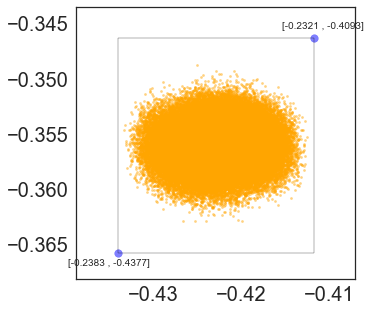

In [73]:
## plot the out points (red points)
# wheather it is over the upper/lower bound points (blue points)

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(out[:,2],out[:,3],s=5,c='orange',marker='o',alpha=0.5,label='C1')
ax.scatter(zl[2],zl[3],s=60,c='blue',marker='o',alpha=0.5,label='C1')
ax.scatter(zu[2],zu[3],s=60,c='blue',marker='o',alpha=0.5,label='C1')

ax.text(zl[2]-0.001, zl[3]-0.001, "[%.4f , %.4f]"%(zl[0],zl[1]), ha="center", va="center", size=10)
ax.text(zu[2]+0.001, zu[3]+0.001, "[%.4f , %.4f]"%(zu[0],zu[1]), ha="center", va="center", size=10)

ax.add_patch(patches.Rectangle((zl[2], zl[3]), zu[2]-zl[2], zu[3]-zl[3], fill=False))

### test tools

##### kernel move

In [323]:
x = torch.arange(75.)
x = torch.reshape(x, (1 ,3, 5, 5))
x

tensor([[[[ 0.,  1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.,  9.],
          [10., 11., 12., 13., 14.],
          [15., 16., 17., 18., 19.],
          [20., 21., 22., 23., 24.]],

         [[25., 26., 27., 28., 29.],
          [30., 31., 32., 33., 34.],
          [35., 36., 37., 38., 39.],
          [40., 41., 42., 43., 44.],
          [45., 46., 47., 48., 49.]],

         [[50., 51., 52., 53., 54.],
          [55., 56., 57., 58., 59.],
          [60., 61., 62., 63., 64.],
          [65., 66., 67., 68., 69.],
          [70., 71., 72., 73., 74.]]]])

In [324]:
kc, kh, kw = 2, 2, 2  # kernel size
dc, dh, dw = 2, 2, 2  # stride
patches = x.unfold(2, kh, dh).unfold(3, kw, dw)
unfold_shape = patches.size()
print(unfold_shape)
patches = patches.contiguous().view(patches.size(0), -1, kh*kw)
print(patches.shape)
print(patches)

torch.Size([1, 3, 2, 2, 2, 2])
torch.Size([1, 12, 4])
tensor([[[ 0.,  1.,  5.,  6.],
         [ 2.,  3.,  7.,  8.],
         [10., 11., 15., 16.],
         [12., 13., 17., 18.],
         [25., 26., 30., 31.],
         [27., 28., 32., 33.],
         [35., 36., 40., 41.],
         [37., 38., 42., 43.],
         [50., 51., 55., 56.],
         [52., 53., 57., 58.],
         [60., 61., 65., 66.],
         [62., 63., 67., 68.]]])


##### reversed block

In [325]:
# Reshape back
patches_orig = patches.view(unfold_shape)
output_h = unfold_shape[2] * unfold_shape[4]
output_w = unfold_shape[3] * unfold_shape[5]
patches_orig = patches_orig.permute(0, 1, 2, 4, 3, 5).contiguous()
patches_orig = patches_orig.view(1, 3, output_h, output_w)
patches_orig.shape

torch.Size([1, 3, 4, 4])

In [326]:
patches_orig

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 5.,  6.,  7.,  8.],
          [10., 11., 12., 13.],
          [15., 16., 17., 18.]],

         [[25., 26., 27., 28.],
          [30., 31., 32., 33.],
          [35., 36., 37., 38.],
          [40., 41., 42., 43.]],

         [[50., 51., 52., 53.],
          [55., 56., 57., 58.],
          [60., 61., 62., 63.],
          [65., 66., 67., 68.]]]])

##### pad (rtght and bottem)

In [328]:
t4d = torch.arange(48.).reshape(1, 3, 4, 4)
p1d = (0,1,0,1)
out = F.pad(t4d, p1d, "constant", 0) 
out

tensor([[[[ 0.,  1.,  2.,  3.,  0.],
          [ 4.,  5.,  6.,  7.,  0.],
          [ 8.,  9., 10., 11.,  0.],
          [12., 13., 14., 15.,  0.],
          [ 0.,  0.,  0.,  0.,  0.]],

         [[16., 17., 18., 19.,  0.],
          [20., 21., 22., 23.,  0.],
          [24., 25., 26., 27.,  0.],
          [28., 29., 30., 31.,  0.],
          [ 0.,  0.,  0.,  0.,  0.]],

         [[32., 33., 34., 35.,  0.],
          [36., 37., 38., 39.,  0.],
          [40., 41., 42., 43.,  0.],
          [44., 45., 46., 47.,  0.],
          [ 0.,  0.,  0.,  0.,  0.]]]])